![deep.png](../deep.png)


# Cross-Validation Lesson


---

### Learning Objectives
- **Describe** train/test split and cross-validation.
- **Explain** how these validation techniques differ and why we want to use them.
- **Split** data into testing and training sets using both train/test split and cross-validation and **apply** both techniques to score a model.

<a id='overfitting-underfitting'></a>

## Overfitting and Underfitting

---

![](http://tomrobertshaw.net/img/2015/12/overfitting.jpg)


**What's wrong with the first model?**
- The underfit model falls short of capturing the complexity of the "true model" of the data.

**What's wrong with the third model?**
- The overfit model is too complex and is modeling random noise in the data.

**The middle model is a good compromise.**
- It approximates the complexity of the true model and does not model random noise in our sample as true relationships.

![](http://image.slidesharecdn.com/nncollovcapaldo2013-131220052427-phpapp01/95/machine-learning-introduction-to-neural-networks-12-638.jpg?cb=1393073301)

**Check 1:** Why is overfitting a problem?

## Importing libraries

---

We'll need the following libraries for today's lesson:
- `pandas`
- `numpy`
- `seaborn`
- from `sklearn.model_selection` we'll need `train_test_split`, `KFold`, and `cross_val_score`
- we'll need a `LinearRegression` from `sklearn.linear_model`
- we'll use the `r2_score` from `sklearn.metrics` to evaluate our model

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score

%matplotlib inline

<a id='demo'></a>

## Load the Data

---

Today's [dataset](http://www-bcf.usc.edu/~gareth/ISL/data.html) (`Advertising.csv`) is from the [ISLR website](http://www-bcf.usc.edu/~gareth/ISL/). 

Drop `Unnamed: 0` once you've loaded the csv into a `DataFrame`.

In [3]:
df = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv')
df.drop('Unnamed: 0', axis = 1, inplace=True)

## Data cleaning

Check the following in the cells below:
1. Do we have any null values?
2. Do we have all numerical columns?

In [4]:
# Check for nulls
df.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [5]:
# Check column data types
df.dtypes

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object

In [6]:
df.head()

TV  radio  newspaper  sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9

### EDA: Plot a Heatmap of the Correlation Matrix

Heatmaps are an effective way to visually examine the correlational structure of your predictors. 

In [7]:
df.corr()

TV     radio  newspaper     sales
TV         1.000000  0.054809   0.056648  0.782224
radio      0.054809  1.000000   0.354104  0.576223
newspaper  0.056648  0.354104   1.000000  0.228299
sales      0.782224  0.576223   0.228299  1.000000

In [8]:
df.corr()[['sales']]

sales
TV         0.782224
radio      0.576223
newspaper  0.228299
sales      1.000000

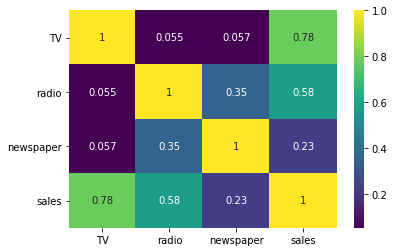

In [9]:
sns.heatmap(df.corr(), annot=True, cmap='viridis')

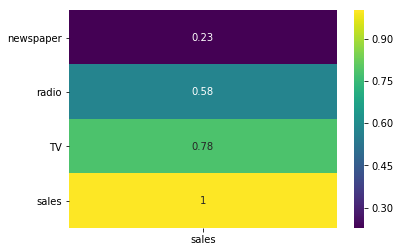

In [10]:
sns.heatmap(df.corr()[['sales']].sort_values('sales'), annot=True, cmap='viridis')

**Check 2:** When are correlation heatmaps useful?

### EDA: Use seaborn's `.pairplot()` method to create scatterplots for each of our columns

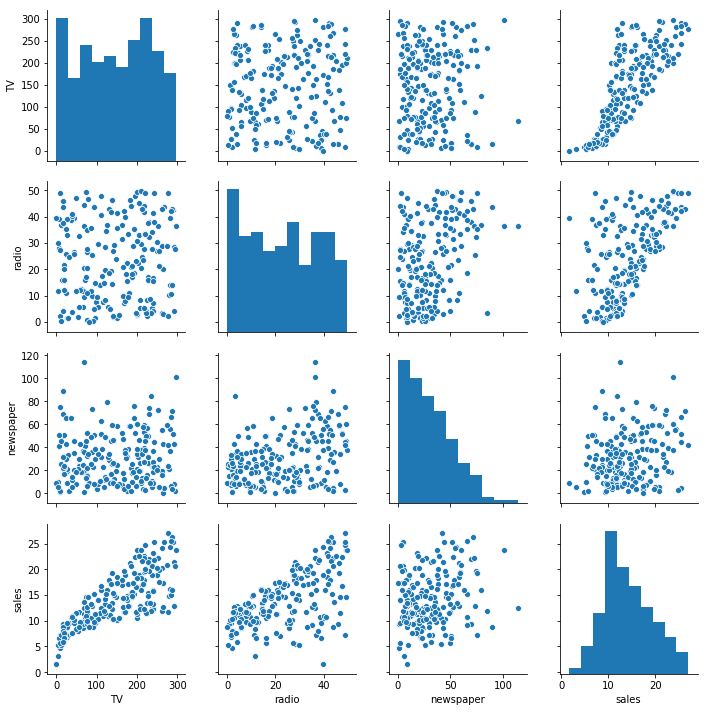

In [11]:
sns.pairplot(df)

<a id='x-y'></a>

### Create our features matrix (`X`) and target vector (`y`)

The following columns will be our features:
- `TV`
- `radio`
- `newspaper`

The `sales` column is our label: the column we're trying to predict.

In the cell below, create your `X` and `y` variables.

In [12]:
features = ['TV', 'radio', 'newspaper']
X = df[features]#list of features is encouraged/required for advanced modeling
#due to the ordered nature of a series
y = df['sales']

<a name="train-test-split"></a>
## Train/Test Split and Model Validation

---

So far we've focused on fitting the best model to our data. But is this the best model for our sample data or the best model overall? How do we know?

In practice we need to validate our model's ability to generalize to new data. One popular method for performing model validation is by splitting our data into subsets: data on which we *train* our model and data on which we *test* our model.

The most basic type of "hold-out" validation is called **train/test split**. We split our data into two pieces:

> **"A Training Set":** The subset of the data on which we fit our model.

> **"A Testing Set":** The subset of the data on which we evaluate the quality of our predictions.


**Train/Test Split Benefits:**

- Testing data can represent "future" data; for prediction-oriented models, it's critical to ensure that a model that is performing well on current data will likely perform well on future data.
- It can help diagnose and avoid overfitting via model tuning.
- It can improve the quality of our predictions.

<a id='sklearn-tts'></a>

### Scikit-Learn's `train_test_split` Function

Performing train/test splits using scikit-learn is easy — load the `train_test_split` function:

```python
from sklearn.model_selection import train_test_split
```

**Arguments**:
- *Arrays*: Any number of arrays/matrices to split up into training and testing sets (they should be the same length).
- `test_size`: An integer representing the exact size of the testing subset or a float for a percentage.
- `train_size`: Alternatively, you can specify the training size.
- `stratify`: Supply a vector to stratify the splitting (by more important classification tasks).
- `random_state`: a numerical seed for randomly splitting your data with reproducibility

**Perform a split of our `X` and `y`.**

In [13]:
train_test_split(X, y, random_state=2)#default is 75% train/25% test

[        TV  radio  newspaper
 159  131.7   18.4       34.6
 100  222.4    4.3       49.8
 11   214.7   24.0        4.0
 187  191.1   28.7       18.2
 24    62.3   12.6       18.3
 89   109.8   47.8       51.4
 66    31.5   24.6        2.2
 8      8.6    2.1        1.0
 172   19.6   20.1       17.0
 175  276.9   48.9       41.8
 28   248.8   27.1       22.9
 133  219.8   33.5       45.1
 94   107.4   14.0       10.9
 42   293.6   27.7        1.8
 169  284.3   10.6        6.4
 82    75.3   20.3       32.5
 184  253.8   21.3       30.0
 106   25.0   11.0       29.7
 108   13.1    0.4       25.6
 143  104.6    5.7       34.4
 180  156.6    2.6        8.3
 166   17.9   37.6       21.6
 146  240.1    7.3        8.7
 79   116.0    7.7       23.1
 1     44.5   39.3       45.1
 119   19.4   16.0       22.3
 192   17.2    4.1       31.6
 149   44.7   25.8       20.6
 160  172.5   18.1       30.7
 188  286.0   13.9        3.7
 ..     ...    ...        ...
 183  287.6   43.0       71.8
 58   210.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [58]:
X_train.head()#shuffled index as output of training X

TV  radio  newspaper
159  131.7   18.4       34.6
100  222.4    4.3       49.8
11   214.7   24.0        4.0
187  191.1   28.7       18.2
24    62.3   12.6       18.3

In [59]:
X_train.shape

(150, 3)

In [60]:
y_train.head()#shuffled index echoed in y

159    12.9
100    11.7
11     17.4
187    17.3
24      9.7
Name: sales, dtype: float64

In [61]:
y_train.shape

(150,)

Check out the docs: [http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Note that we could always split the data up manually. Here's an example for of manually split code for [this data set](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py).

<a id='fit-on-train'></a>

### Linear Regression model

In the cell below, create a `LinearRegression` model.

In [62]:
lr = LinearRegression()

In [63]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
lr.score(X_train, y_train)

0.9322395888715463

In [65]:
lr.score(X_test, y_test)

0.7558194773721318

<a id='cross-val-k-fold'></a>

## K-Fold Cross-Validation

---

K-fold cross-validation takes the idea of a single train/test split and expands it to *multiple tests* across different train/test splits of your data.

For example, if you determine your training set will contain 80 percent of the data and your testing set will contain the other 20 percent, you could have five different 80/20 splits in which the test set in each is a different set of observations. We have:
- Five (K=5) training sets.
- Five (K=5) corresponding testing sets.

**K-fold cross-validation builds K models — one for each train/test pair — and evaluates those models on each respective test set.**

### K-Fold Cross-Validation Visually

<img src="https://snag.gy/o1lLcw.jpg?convert_to_webp=true" width="500">

---

Cross-validation helps us understand how a model parameterization may perform in a variety of cases. The k-fold cross-validation procedure can be described in pseudocode:

```
set k
create k groups of rows in data

for group i in k row groups:
    test data is data[group i]
    train data is data[all groups not i]
    
    fit model on train data
    
    score model on test data
    
evaluate mean of k model scores
evaluate variance of k model scores
```

Odd case No. 1:
> **When K=2**: This is equivalent to performing ***two*** mirror image 50-50 train/test splits.

Odd case No. 2:
> **When K=number of rows**: This is known as "leave-one-out cross-validation," or LOOCV. A model is built on all but one row and tested on the single excluded observation.

### K-Folds Cross Validation in `sklearn`

Now let's try out k-fold cross-validation. Again, scikit-learn provides useful functions to do the heavy lifting. 

The function `cross_val_score` returns the $R^2$ for each testing set. 

In the cells below, create a `KFold` object and score your training set (`X_train`, `y_train`) using `cross_val_score`.


In [68]:
cv_scores = cross_val_score(lr, X_train, y_train, cv = 5)

In [69]:
cv_scores

array([0.91177672, 0.9277913 , 0.90754028, 0.92687225, 0.9217498 ])

### K-Fold challenge:

In the cell bellow, manually recreate the results from `cross_val_score` using a `for` loop.

In [71]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)    

In [74]:
X_train.values[:,:]

array([[131.7,  18.4,  34.6],
       [222.4,   4.3,  49.8],
       [214.7,  24. ,   4. ],
       [191.1,  28.7,  18.2],
       [ 62.3,  12.6,  18.3],
       [109.8,  47.8,  51.4],
       [ 31.5,  24.6,   2.2],
       [  8.6,   2.1,   1. ],
       [ 19.6,  20.1,  17. ],
       [276.9,  48.9,  41.8],
       [248.8,  27.1,  22.9],
       [219.8,  33.5,  45.1],
       [107.4,  14. ,  10.9],
       [293.6,  27.7,   1.8],
       [284.3,  10.6,   6.4],
       [ 75.3,  20.3,  32.5],
       [253.8,  21.3,  30. ],
       [ 25. ,  11. ,  29.7],
       [ 13.1,   0.4,  25.6],
       [104.6,   5.7,  34.4],
       [156.6,   2.6,   8.3],
       [ 17.9,  37.6,  21.6],
       [240.1,   7.3,   8.7],
       [116. ,   7.7,  23.1],
       [ 44.5,  39.3,  45.1],
       [ 19.4,  16. ,  22.3],
       [ 17.2,   4.1,  31.6],
       [ 44.7,  25.8,  20.6],
       [172.5,  18.1,  30.7],
       [286. ,  13.9,   3.7],
       [243.2,  49. ,  44.3],
       [266.9,  43.8,   5. ],
       [164.5,  20.9,  47.4],
       [16

In [76]:
X_train.values[[0,2],:]

array([[131.7,  18.4,  34.6],
       [214.7,  24. ,   4. ]])

In [77]:
from sklearn import base

for train_idx, test_idx in list (kf.split(X_train, y_train)):
    X_train_fold = X_train.values[train_idx, :]
    y_train_fold = y_train.values[train_idx]
    
    X_test_fold = X_train.values(test_idx, :)
    y_test_fold = y_train.values(test_idx)
    
    fold_model = base.clone(lr)
    fold_model.fit(X_train_fold, y_train_fold)
    print (fold_model.score(X_test_fold, y_test_fold))

SyntaxError: invalid syntax (<ipython-input-77-008bc19ba5b3>, line 4)

**Check 5:** K-Fold Cross Validation Summary

<a id='hold-out'></a>

## Hold-Out Sets

---

Hold-out sets are a version of train/test split. To create a hold-out set, you:

1) **Split data into a large training and a small testing set. This small testing set will be the "hold-out" set.**

2) **For a set of different model parameterizations:**

    1) Set up the model.
    2) Cross-validate the current model on the training data.
    3) Save the model performance.

3) **Select the model that performed best using cross-validation on the training data.**

4) **Perform a final test of that model on the original "hold-out" test set.**

> **Note:** The "hold-out" method is more conservative, but also requires you to have more data. With smaller data sets it can be infeasible.

The graphic below explains the hold-out method visually:

![](./assets/Train-Test-Split-CV.png)

In [79]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.9191460687998652

In [80]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9322395888715463

In [81]:
lr.score(X_test, y_test)#divergence between cross_val score and lr score
#suggests that a better score can be achieved
#

0.7558194773721318

<a id='additional-resources'></a>

## Additional Resources

---

- [Cross-Validation Example](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py).
- [Plotting Cross-Validated Predictions](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html).
- Review this [academic paper](http://frostiebek.free.fr/docs/Machine%20Learning/validation-1.pdf) on the underpinnings of the hold-out method, LOOCV, and k-folds.
- Review the scikit-learn [documentation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) on cross-validation.
- Review this [Stanford lesson](https://www.youtube.com/watch?v=_2ij6eaaSl0) on cross-validation.
- Review this [blog post](http://www.win-vector.com/blog/2015/01/random-testtrain-split-is-not-always-enough/) on why TTS is not always sufficient.
- Review this Stack Exchange [discussion](http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio) on approximate TTS and validation set sizes.